이미지 전처리 -> pre_processing()


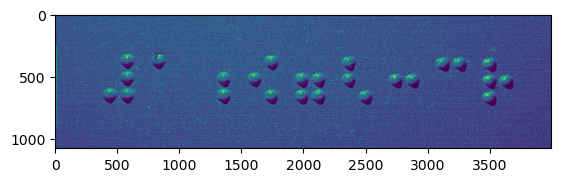

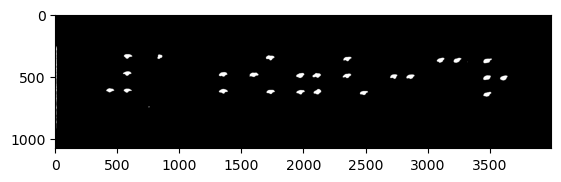


 점자 좌표 탐색 -> find_location()


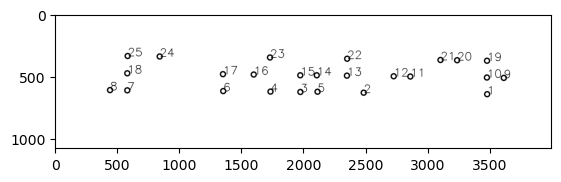


 점자 좌표 보정 -> modify_location()


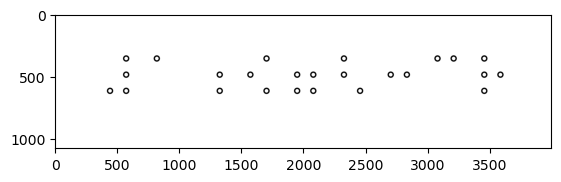


 점자 추출 -> find_braille()


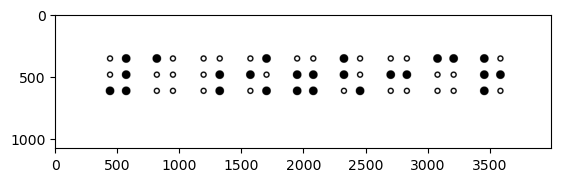

(0, 0, 1, 1, 1, 1)
(1, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 1, 1)
(0, 1, 0, 1, 0, 1)
(0, 1, 1, 0, 1, 1)
(1, 1, 0, 0, 0, 1)
(0, 1, 0, 0, 1, 0)
(1, 0, 0, 1, 0, 0)
(1, 1, 1, 0, 1, 0)


In [1]:
# 점자 간의 간격 구하는 알고리즘 추가

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img)
    plt.show()

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    
    plt.imshow(thresh_cv, cmap = 'gray')
    plt.show()

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
        if cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0:  
            M = cv2.moments(i)

            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            center_list.append([cx, cy])
            center = np.append(center, np.array([[cx, cy]]), axis=0)

            cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
            cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
            num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 점자 간의 간격 구하기
    test = [abs(standard_x[i] - standard_x[i+1]) for i in range(len(standard_x) - 1) \
            if abs(standard_x[i] - standard_x[i+1]) > dist * 1.3]
    
    cls, std = standard(np.array(test))
    
    inter = std[0]  # 점자 간의 간격
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]], inter)
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]], inter)  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist], inter)  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    num = 1
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 30:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x, inter):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
            new_x = all_x[-1] + inter

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        if new_x > standard[-1] - (dist * 0.7):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    new = [abs(j - standard[0]) for j in x_list]  # 편차 리스트
    num = min(new)
    temp = num + standard[0] if num + standard[0] in x_list else standard[0] - num
    change.append(temp)

    for i in range(1, len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist




# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\test2.jpg')  